# Lab N
### Morphology

Skimage morphology operators' documentation:
https://scikit-image.org/docs/dev/api/skimage.morphology.html

In [2]:
from commonfunctions import *
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin
from skimage.filters import threshold_otsu, threshold_mean, threshold_minimum, threshold_local
from skimage.measure import find_contours
from skimage.draw import rectangle

# Show the figures / plots inside the notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

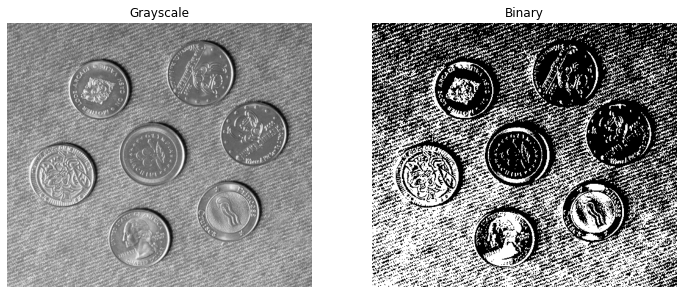

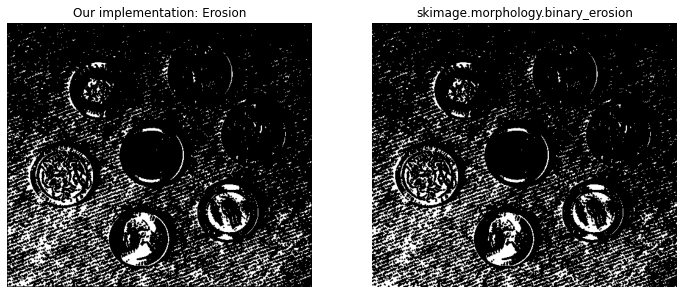

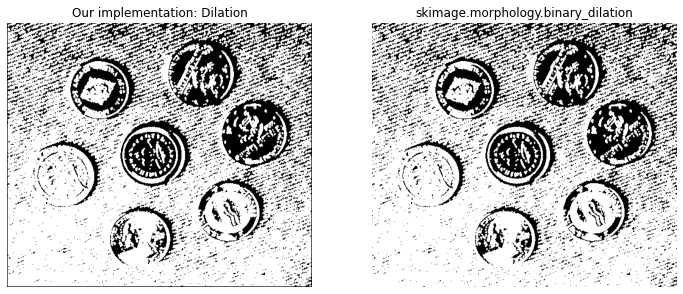

In [3]:
'''
1) Erosion / Dilation:
    - Load "coins.jpg" from the img folder
    - Convert the image to binary
    - Write 2 functions each applying 1 of the erosion/dilation algorithms (with adjustable square window size) manually to the binary image
    - Use Skimage's "binary_erosion" & "binary_dilation" & show the results
'''
class Experiment1:
    # Create an empty image that matches the original image
    # Fill each pixel if the structuring element fits the original image
    # Currently only uses odd squareSizes
    ERODE = np.all
    DILATE = np.any
    def morph(image, operator, SE, squareSize):
        if squareSize % 2 == 0: return None
        morphed = np.zeros(image.shape, dtype=bool)
        offset = squareSize // 2
        
        for i in range(offset, image.shape[0]-offset):
            for j in range(offset, (image.shape[1])-offset):
                neighborhood = image[i-offset: i+offset+1, j-offset: j+offset+1]
                p = neighborhood * SE
                morphed[i, j] = operator(p == SE) and np.any(p)
        
        return morphed
    
    def run(squareSize=3):
        coins = io.imread('img/coins.jpg', as_gray=True)
        threshold = threshold_otsu(coins)
        # threshold = threshold_local(coins, 35, offset=10)

        # Cross SE
        SE = np.zeros((squareSize, squareSize), dtype=bool)
        SE[squareSize//2, :] = 1
        SE[:, squareSize//2] = 1

        binaryCoins = coins > threshold
        erodedCoins = Experiment1.morph(binaryCoins, Experiment1.ERODE, SE, squareSize)
        dilatedCoins = Experiment1.morph(binaryCoins, Experiment1.DILATE, SE, squareSize)
        
        show_images([coins, binaryCoins], ['Grayscale', 'Binary'])
        show_images([erodedCoins, binary_erosion(binaryCoins)], 
                    ['Our implementation: Erosion', 'skimage.morphology.binary_erosion'])
        show_images([dilatedCoins, binary_dilation(binaryCoins)], 
                    ['Our implementation: Dilation', 'skimage.morphology.binary_dilation'])


Experiment1.run()

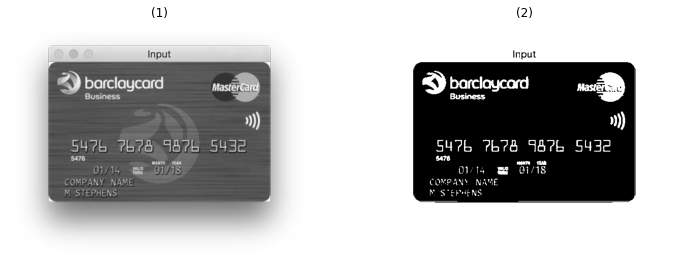

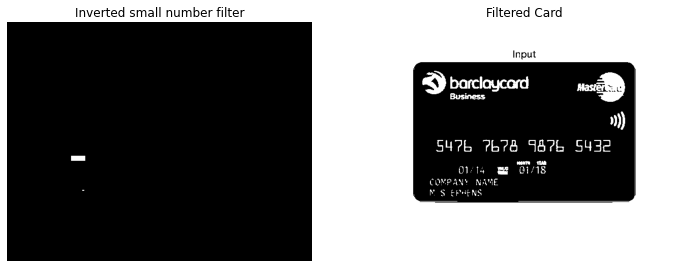

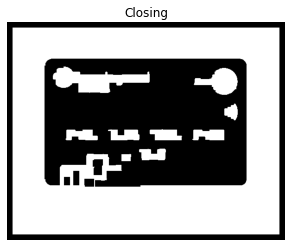

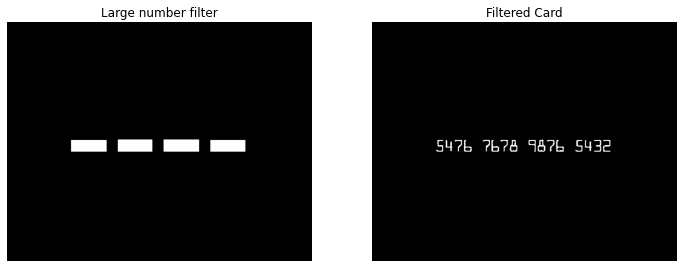

In [28]:
'''
2) Case Study: Credit Card Number Extraction
    - Load "card.jpg" from the img folder
    - Convert the image to binary by brightness thresholding maintaining the card number details for extraction
    - Use your erosion/dilation functions, or Skimage's functions only if you didn't implement them, to apply closing
        Note: The goal of this step is to join the card number into 4 sets of connected pixels
    - Use Skimage's "find_contours" to get the bounding boxes for the credit card's numbers by filtering on aspect ratio (between 2.5 & 3.5)
        Note: When using "find_contours(img, 0.8)" the o/p is a list of contours each having:
                - contour[:,0] being the Y values of the contour perimeter points
                - contour[:,1] being the X values of the contour perimeter points
'''

class Experiment2:
    def closing(image, SE, squareSize=3):
        dilatedImage = Experiment1.morph(image, Experiment1.DILATE, SE, squareSize)
        closedImage = Experiment1.morph(dilatedImage, Experiment1.ERODE, SE, squareSize)
        return dilatedImage, closedImage
    
    # When provided with the correct format of the list of bounding_boxes, this section will set all pixels inside boxes in img_with_boxes
    def set_pixels(img, bounding_boxes):
        img_with_boxes = np.copy(img)
        for box in bounding_boxes:
            [Xmin, Xmax, Ymin, Ymax] = box
            rr, cc = rectangle(start=(Ymin, Xmin), end=(Ymax, Xmax), shape=img.shape)
            img_with_boxes[rr, cc] = 1 # set color white
        return img_with_boxes
    
    def get_bounding_boxes(img):
        boundingBoxes = []
        contours = find_contours(img, 0.8)
        for c in contours:
            xValues = np.round(c[:, 1]).astype(int)
            yValues = np.round(c[:, 0]).astype(int)
            ar = (xValues.max() - xValues.min()) / (yValues.max() - yValues.min())
    
            if 2.5 < ar < 3.5:
                boundingBoxes.append([xValues.min(), xValues.max(), yValues.min(), yValues.max()])
                
        return boundingBoxes      
    
    def run():
        card = (io.imread('img/card.jpg', as_gray=True) * 255).astype(np.uint8)
        threshold = threshold_minimum(card)
        # threshold = threshold_local(card, 401)
        binaryCard = card > threshold
        show_images([card, binaryCard])

        # Create the mask to remove the smaller numbers first
        # Box SE
        SQUARE_SIZE = 3
        SE = np.ones((SQUARE_SIZE, SQUARE_SIZE), dtype=bool)
        d, c = Experiment2.closing(binaryCard, SE, SQUARE_SIZE)
        mask = Experiment2.set_pixels(np.zeros(binaryCard.shape), Experiment2.get_bounding_boxes(c))
        binaryCard = np.where(mask, False, binaryCard)
        show_images([mask, binaryCard], ['Inverted small number filter', 'Filtered Card'])

        # Then create the mask for the bigger numbers
        SQUARE_SIZE = 13
        SE = np.ones((SQUARE_SIZE, SQUARE_SIZE), dtype=bool)
        d, c = Experiment2.closing(binaryCard, SE, SQUARE_SIZE)
        mask = Experiment2.set_pixels(np.zeros(binaryCard.shape), Experiment2.get_bounding_boxes(c))
        binaryCard = np.where(mask, binaryCard, False)
        show_images([c], ['Closing'])
        show_images([mask, binaryCard], ['Large number filter', 'Filtered Card'])


Experiment2.run()


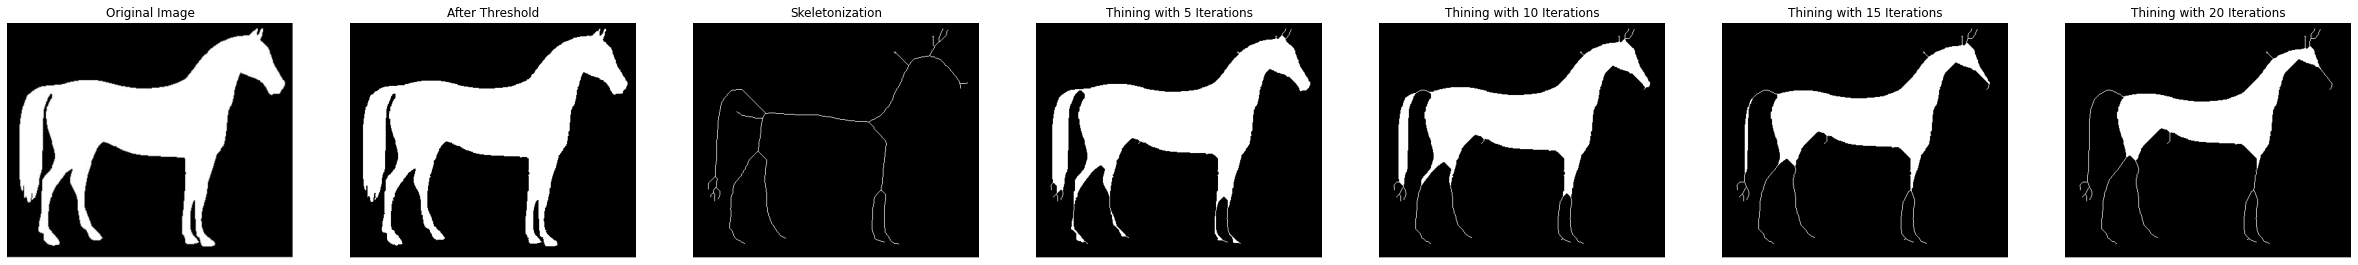

In [5]:
'''
3) Skeletonization:
    - Load "horse.jpg" from the img folder 
    - Use a binary threshold of 0.9 to remove invisible noise in the background
    - Use Skimage's "skeletonize(image)" to acquire the image's skeleton & show it
    - Use Skimage's "thin(image, max_iter)" with values of max_iter 5/10/15/20 & show it
'''
imgsArray = []
labelArray = []

horseImg = io.imread('img/horse.jpg',True)

imgsArray.append(horseImg)
labelArray.append("Original Image")

horseThresholdImg = horseImg > 0.9

imgsArray.append(horseThresholdImg)
labelArray.append("After Threshold")

skeletonizedImage = skeletonize(horseThresholdImg)

imgsArray.append(skeletonizedImage)
labelArray.append("Skeletonization")

maxItr5 = thin(horseThresholdImg,5)
maxItr10 = thin(horseThresholdImg,10)
maxItr15 = thin(horseThresholdImg,15)
maxItr20 = thin(horseThresholdImg,20)

imgsArray.append(maxItr5)
labelArray.append("Thining with 5 Iterations")
imgsArray.append(maxItr10)
labelArray.append("Thining with 10 Iterations")
imgsArray.append(maxItr15)
labelArray.append("Thining with 15 Iterations")
imgsArray.append(maxItr20)
labelArray.append("Thining with 20 Iterations")

show_images(imgsArray,labelArray)
